# Librerias

In [1]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten,MaxPooling2D, BatchNormalization
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
import librosa
import librosa.display
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

#Dataset


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Aprendizaje Estadistico/identificarPajaros/training_PrimaryEncoded.csv') #solo las columnas de interes

# Espectrograma de los audios

In [3]:
D=[]

for row in data.itertuples():
    #print(row)
    y,sr=librosa.load('/content/drive/MyDrive/Aprendizaje Estadistico/identificarPajaros/train_audio/' + row.filename,duration=2.95 )
    s=librosa.feature.melspectrogram(y=y,sr=sr)
    ps=librosa.power_to_db(s)
    ps=ps.astype(np.float32)
    # Si no tienen tamaño uniforme no se incluye en la variable D
    if ps.shape != (128,128):
      continue
    D.append((ps,row.primary_label_encoded)) #desde aqui es donde se asocia un espectro a un nombre de pajaro


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=769
  n_fft, y.shape[-1]


#Particion de datos Train-Test-Validacion


In [4]:
random.shuffle(D)

D_train=[]
D_valid=[]
D_test=[]

#formo las listas de entrenamiento, test, validacion

for i in range(0,2322):
  D_train.append(D[i])

for i in range(2322,2985):
  D_test.append(D[i])  

for i in range(2985,3253):
  D_valid.append(D[i]) 

#%% Preparamos el dataset, desordenando las muestras y separándolas en muestras para entrenar, para evaluar y para testear
dataset_train=D_train
dataset_valid=D_valid
dataset_test=D_test

random.shuffle(dataset_train)
random.shuffle(dataset_valid)
random.shuffle(dataset_test)


train=dataset_train
valid=dataset_valid
test=dataset_test

X_train, y_train = zip(*train)
X_valid, y_valid = zip(*valid)
X_test, y_test = zip(*test)

X_train = np.array([x.reshape( (128, 128, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (128, 128, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (128, 128, 1) ) for x in X_test])

#Normalizacion de los datos

In [5]:
# Normalización
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_valid = (X_valid - mean)/std
X_test = (X_test - mean)/std

y_train = np.array(keras.utils.to_categorical(y_train, num_classes=134))
y_valid = np.array(keras.utils.to_categorical(y_valid, num_classes=134))
y_test = np.array(keras.utils.to_categorical(y_test, num_classes=134))

#Modelo neuronal 1

In [ ]:
#%% Construimos el modelo propuesto y lo compilamos
model = Sequential()
input_shape=(128, 128, 1) #dimension de entrada


model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape)) #convolucional 1 con 24 filtros de 5x5
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))   #convolucional 2 con 48 filtros de 5x5
model.add(MaxPooling2D((4, 2), strides=(4, 2))) #maxpooling con filtro de 4x2
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))  #convolucional 3
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(30)) #capa densa de 64 neuronas
model.add(Activation('relu'))

model.add(Dropout(rate=0.5))
model.add(Dense(134))             #134 porque son las posibles categorias 'salidas' de mis audios
model.add(Activation('softmax'))
adam = Adam(0.0001)

# Compilacion y fit modelo 1

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
callbacks = [ModelCheckpoint(filepath='best_model.h5', verbose=1,monitor='val_loss', save_best_only=True,mode='min'),EarlyStopping(monitor='val_loss', patience=10, verbose=1,mode='min')]
history = model.fit(x=X_train,y=y_train,epochs=50,batch_size=5,validation_data = (X_valid,y_valid),callbacks=callbacks)


Epoch 1/50
464/465 [============================>.] - ETA: 0s - loss: 4.6771 - accuracy: 0.0332
Epoch 1: val_loss improved from inf to 4.43713, saving model to best_model.h5
465/465 [==============================] - 44s 93ms/step - loss: 4.6765 - accuracy: 0.0332 - val_loss: 4.4371 - val_accuracy: 0.0299
Epoch 2/50
464/465 [============================>.] - ETA: 0s - loss: 4.4558 - accuracy: 0.0392
Epoch 2: val_loss improved from 4.43713 to 4.39010, saving model to best_model.h5
465/465 [==============================] - 44s 96ms/step - loss: 4.4552 - accuracy: 0.0392 - val_loss: 4.3901 - val_accuracy: 0.0261
Epoch 3/50
464/465 [============================>.] - ETA: 0s - loss: 4.4288 - accuracy: 0.0379
Epoch 3: val_loss did not improve from 4.39010
465/465 [==============================] - 43s 92ms/step - loss: 4.4283 - accuracy: 0.0383 - val_loss: 4.4049 - val_accuracy: 0.0299
Epoch 4/50
464/465 [============================>.] - ETA: 0s - loss: 4.3962 - accuracy: 0.0431
Epoch 4: v

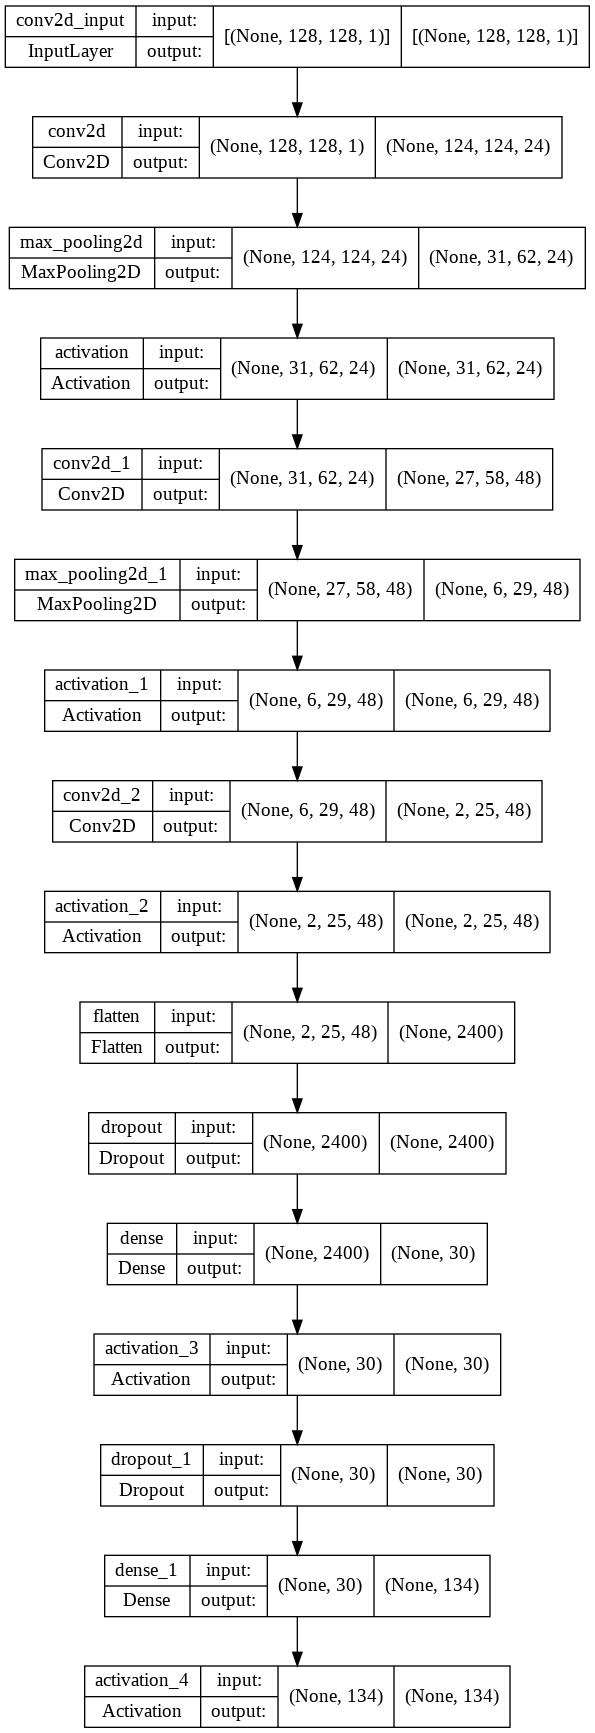

In [ ]:
tf.keras.utils.plot_model(model,  show_shapes=True)

# Curvas de aprendizaje modelo 1


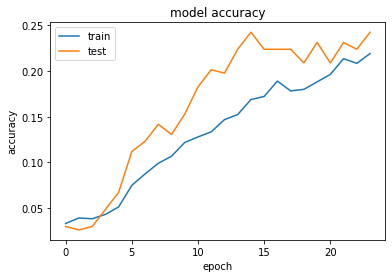

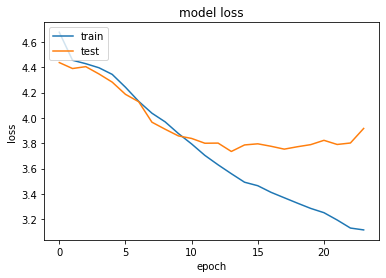

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Modelo 2

In [6]:
model2 = Sequential()
input_shape=(128, 128, 1)
model2.add(Conv2D(32, (4, 10), padding="same",
input_shape=input_shape))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D())
model2.add(Conv2D(32, (4, 10), padding="same"))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D())
model2.add(Conv2D(32, (4, 10), padding="same"))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D())
model2.add(Conv2D(32, (4, 10), padding="same"))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D())
model2.add(Flatten())
model2.add(Dense(134))
model2.add(BatchNormalization())
model2.add(Activation("softmax"))
model2.add(Dense(134))
model2.add(Activation("softmax"))
adam = Adam(0.0001)

# Compilacion y ejecucion modelo 2

In [ ]:
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#callbacks = [ModelCheckpoint(filepath='best_model2.h5', verbose=1,monitor='val_loss', save_best_only=True,mode='min'),EarlyStopping(monitor='val_loss', patience=10, verbose=1,mode='min')]
callbacks = [ModelCheckpoint(filepath='best_model2v2.h5', verbose=1,monitor='val_loss', save_best_only=True,mode='min')]
history = model2.fit(x=X_train,y=y_train,epochs=200,batch_size=5,validation_data = (X_valid,y_valid),callbacks=callbacks)

Epoch 1/200
465/465 [==============================] - ETA: 0s - loss: 2.6352 - accuracy: 0.3428
Epoch 1: val_loss improved from inf to 3.52053, saving model to best_model2v2.h5
465/465 [==============================] - 165s 352ms/step - loss: 2.6352 - accuracy: 0.3428 - val_loss: 3.5205 - val_accuracy: 0.1828
Epoch 2/200
465/465 [==============================] - ETA: 0s - loss: 2.6036 - accuracy: 0.3570
Epoch 2: val_loss improved from 3.52053 to 3.50913, saving model to best_model2v2.h5
465/465 [==============================] - 165s 356ms/step - loss: 2.6036 - accuracy: 0.3570 - val_loss: 3.5091 - val_accuracy: 0.2239
Epoch 3/200
465/465 [==============================] - ETA: 0s - loss: 2.5732 - accuracy: 0.3669
Epoch 3: val_loss did not improve from 3.50913
465/465 [==============================] - 164s 353ms/step - loss: 2.5732 - accuracy: 0.3669 - val_loss: 3.5704 - val_accuracy: 0.1978
Epoch 4/200
465/465 [==============================] - ETA: 0s - loss: 2.5751 - accuracy: 0

In [1]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

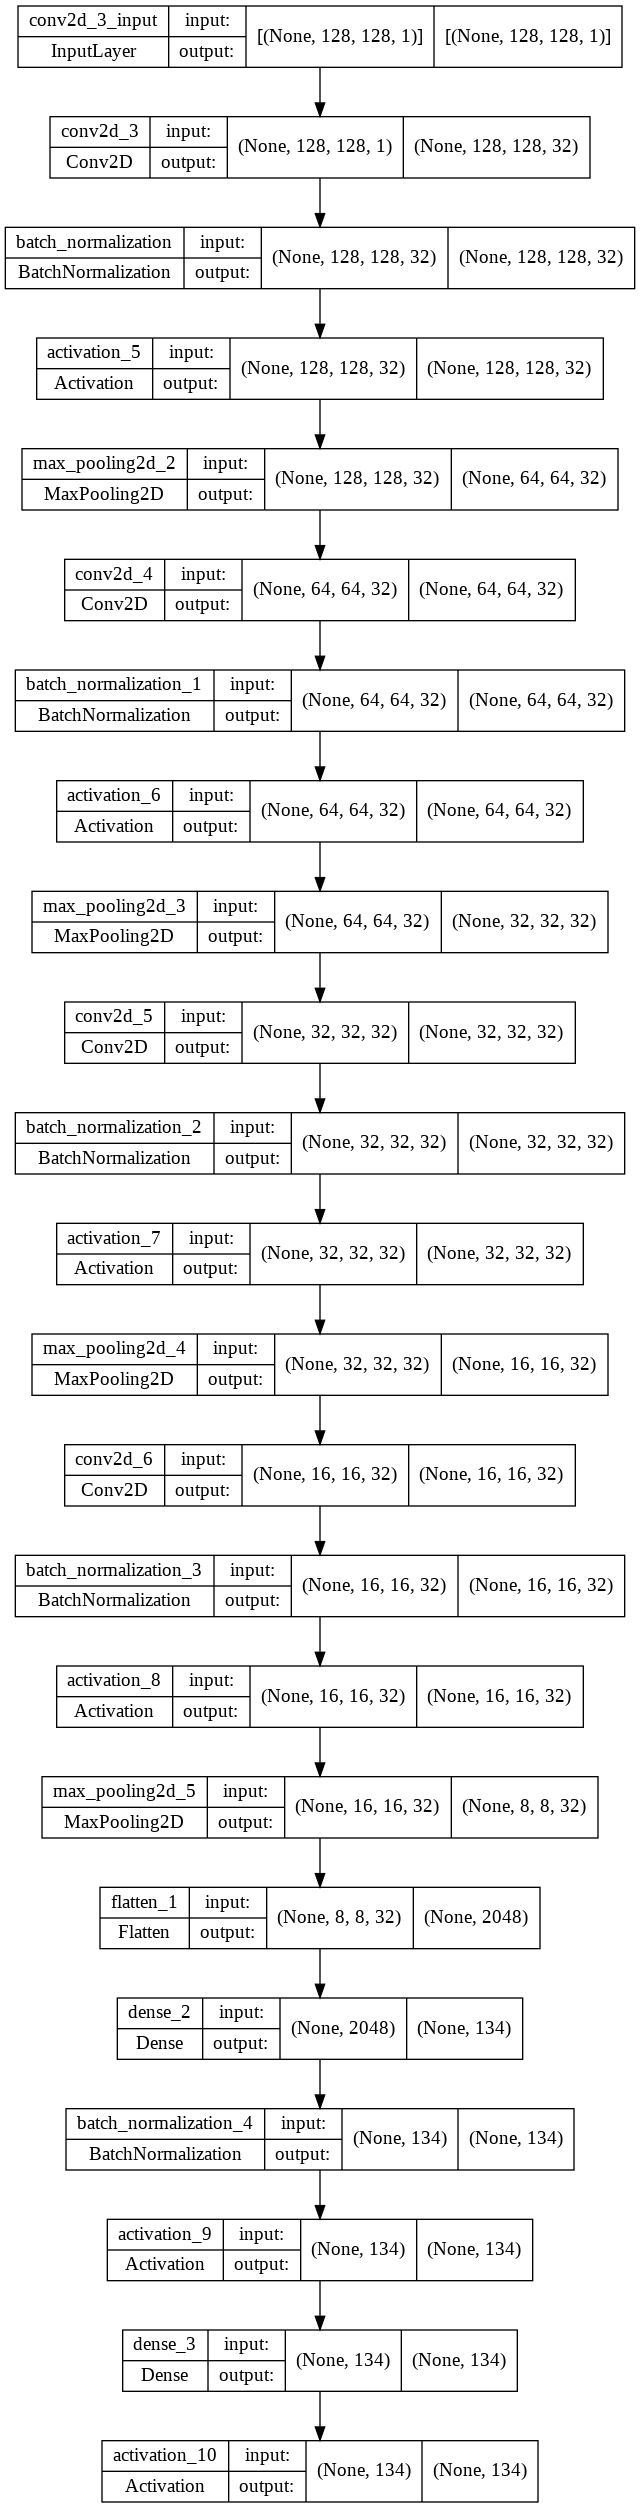

In [ ]:
tf.keras.utils.plot_model(model2,  show_shapes=True)

In [ ]:
model_best = load_model('best_model2.h5')
score = model_best.evaluate(x=X_test,
 y=y_test,
 batch_size=64)